<center><h1>Oversampling with BC4</h1>
John Ignacio R.M. October 2020 </center>

In [1]:
# Libraries
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada.data import read_dataset, split_dataset, rotate_vectors
from ada.model import BinaryClassifierModel4 as BC4
from ada.plot import plot_confidence_matrix
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
import os

Using TensorFlow backend.
Welcome to JupyROOT 6.20/04


In [2]:
# Constants
source_path = "../../processed_data/xtohhOct2020"
dest_path = "../../saved_models/oct_2020"
signal = "Xtohh2000"
bg = "Xtohh_background"
seed = 420
region = "SR"
tag = 2

In [3]:
# Read dataset
df = read_dataset(source_path, signal, bg, region, tag)
df.head()

,EventWeight,label,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,0.001020,1,885.55927,0.104927,-2.448576,127604.30,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.88724,1631.6702,263.697630
1,0.001117,1,855.69904,0.313113,-1.859287,122862.90,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.03333,1293.4028,463.512360
2,0.000925,1,552.47845,-0.702952,-2.549875,109091.67,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.55922,1659.8483,80.008150
3,0.001158,1,525.10590,-0.941433,-1.130162,82382.28,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.60722,1075.3092,109.524925
4,0.001120,1,916.44147,-0.683193,1.804695,115936.01,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.35030,1595.7611,244.283460


In [4]:
# Splitting dataset
sets = split_dataset(df, 0.5, 0.3, 0.2, seed)

# First oversampling method

In [5]:
x = sets["x"]["train"]
y = sets["y"]["train"]
w = sets["w"]["train"]

In [11]:
x_res, y_res = SMOTE(0.2, random_state = seed).fit_resample(x, y)
w_mean = w.mean()
y_res = rotate_vectors([y_res])[0]
w_res = np.concatenate([w, np.full((x_res.shape[0]- x.shape[0], ), w_mean)])

In [21]:
model = BC4(x_res.shape[1])
model.fit(
    x_res, y_res, w_res,
    sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
    50,
)

Train on 4668 samples, validate on 3019 samples
Epoch 1/50
4668/4668 [==============================] - 1s 251us/step - loss: 4.5058e-04 - val_loss: 2.6908e-04
Epoch 2/50
4668/4668 [==============================] - 0s 44us/step - loss: 3.4587e-04 - val_loss: 2.6085e-04
Epoch 3/50
4668/4668 [==============================] - 0s 42us/step - loss: 3.0377e-04 - val_loss: 2.4035e-04
Epoch 4/50
4668/4668 [==============================] - 0s 42us/step - loss: 2.7408e-04 - val_loss: 2.2752e-04
Epoch 5/50
4668/4668 [==============================] - 0s 43us/step - loss: 2.4895e-04 - val_loss: 2.1936e-04
Epoch 6/50
4668/4668 [==============================] - 0s 42us/step - loss: 2.3782e-04 - val_loss: 2.3356e-04
Epoch 7/50
4668/4668 [==============================] - 0s 44us/step - loss: 2.2335e-04 - val_loss: 2.0014e-04
Epoch 8/50
4668/4668 [==============================] - 0s 41us/step - loss: 2.3093e-04 - val_loss: 2.0774e-04
Epoch 9/50
4668/4668 [==============================] - 0s 42us

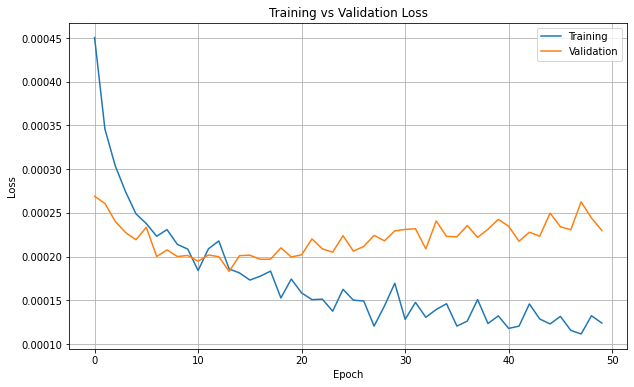

In [22]:
model.plot_loss()

Accuracy: 0.9571455347250488


,0,1,macro avg,weighted avg
precision,0.928208,0.962194,0.945201,0.956414
recall,0.810724,0.987150,0.898937,0.957146
f1-score,0.865498,0.974512,0.920005,0.955972
support,0.397218,1.938392,2.335610,2.335610


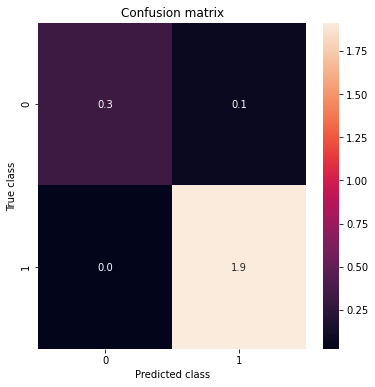

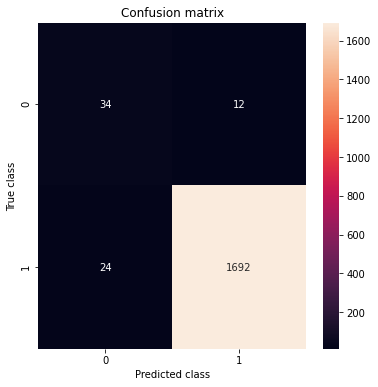

In [23]:
eval = model.complete_evaluation(
    sets["x"]["test"], sets["y"]["test"], sets["w"]["test"], 0.4,
)
print("Accuracy:", eval["weighted_accuracy"])
display(pd.DataFrame(eval["weighted_class_report"]))
plot_confidence_matrix(eval["weighted_cm"], 6, 6, '.1f')
plot_confidence_matrix(eval["cm"], 6, 6, 'd')

# Tuning

In [13]:
def oversampling_score(model, oversampler, minority_ratio, sets, seed, ths, dest_path, title):
    x = sets["x"]["train"]
    y = sets["y"]["train"]
    w = sets["w"]["train"]
    # Oversmpling
    x_res, y_res = oversampler(minority_ratio, random_state = seed).fit_resample(x, y)
    w_mean = w.mean()
    y_res = rotate_vectors([y_res])[0]
    w_res = np.concatenate([w, np.full((x_res.shape[0]- x.shape[0], ), w_mean)])
    # Training
    model = BC4(x_res.shape[1])
    if os.path.exists(f"{dest_path}/{model.model_name}_{title}.h5"):
        print("Loading:", title)
        model.load(dest_path, f"{title}")
    else:
        print("Training:", title)
        model.fit(
            x_res, y_res, w_res,
            sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
            50, verbose = 0
        )
        model.save(dest_path, f"{title}")
    # F1 scores per th
    return pd.DataFrame.from_dict({
        th: model.f1(sets["x"]["test"], sets["y"]["test"], sets["w"]["test"], th) for th in ths
    }, orient="index", columns = [0, 1, "wavg"])

In [14]:
def get_scores_per_oversample(model, oversamplers, ratios, sets, seed, ths, dest_path, title):
    #oversamplers = {"smote": SMOTE, "asadyn": ASADYN}
    #ratios = [10, 20, 30]
    return pd.concat({name: pd.concat({
        ratio: oversampling_score(model, oversampler, ratio/100.0, sets, seed, ths, dest_path, f"{name}_{ratio}_{title}")
        for ratio in ratios
    }) for name, oversampler in oversamplers.items()})

In [15]:
scores_per_oversample = get_scores_per_oversample(BC4, {"smote": SMOTE, "adasyn": ADASYN}, range(10,60,10), sets, seed, np.arange(0.1, 1, 0.1), dest_path, "SR2_Oct2020")

Loading: smote_10_SR2_Oct2020
Loading: smote_20_SR2_Oct2020
Loading: smote_30_SR2_Oct2020
Loading: smote_40_SR2_Oct2020
Loading: smote_50_SR2_Oct2020
Loading: adasyn_10_SR2_Oct2020
Loading: adasyn_20_SR2_Oct2020
Loading: adasyn_30_SR2_Oct2020
Loading: adasyn_40_SR2_Oct2020
Loading: adasyn_50_SR2_Oct2020


In [16]:
scores_per_oversample.nlargest(10, [0])

0         1      wavg
adasyn 20 0.7  0.930044  0.984539  0.975271
          0.4  0.916455  0.982801  0.971517
       30 0.3  0.909644  0.981422  0.969215
       50 0.3  0.909146  0.981313  0.969040
       20 0.8  0.908588  0.979212  0.967201
          0.5  0.908357  0.980930  0.968588
       50 0.4  0.905793  0.980329  0.967652
       20 0.6  0.902592  0.979574  0.966482
          0.9  0.900147  0.975501  0.962686
       30 0.7  0.898913  0.976992  0.963713

In [17]:
scores_per_oversample.nlargest(10, ["wavg"])

0         1      wavg
adasyn 20 0.7  0.930044  0.984539  0.975271
          0.4  0.916455  0.982801  0.971517
       30 0.3  0.909644  0.981422  0.969215
       50 0.3  0.909146  0.981313  0.969040
       20 0.5  0.908357  0.980930  0.968588
       50 0.4  0.905793  0.980329  0.967652
       20 0.8  0.908588  0.979212  0.967201
          0.6  0.902592  0.979574  0.966482
       30 0.4  0.897617  0.978610  0.964836
          0.5  0.898176  0.978316  0.964686

# Adasyn oversampling with 0.2 minority class ratio 

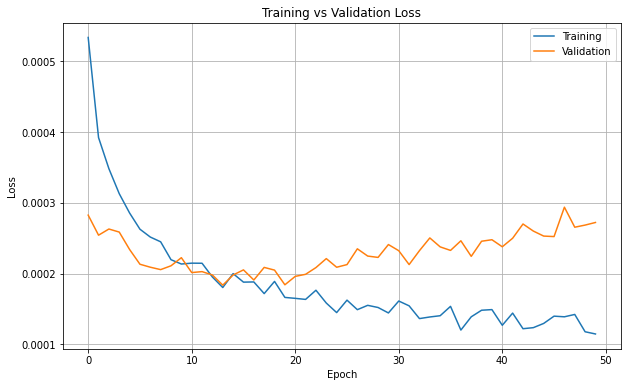

In [18]:
model = BC4(sets["x"]["train"].shape[1])
model.load(dest_path, "adasyn_20_SR2_Oct2020")
model.plot_loss()

Accuracy: 0.9661268440637523


,0,1,macro avg,weighted avg
precision,0.839672,0.997836,0.918754,0.970937
recall,0.989828,0.961270,0.975549,0.966127
f1-score,0.908588,0.979212,0.943900,0.967201
support,0.397218,1.938392,2.335610,2.335610


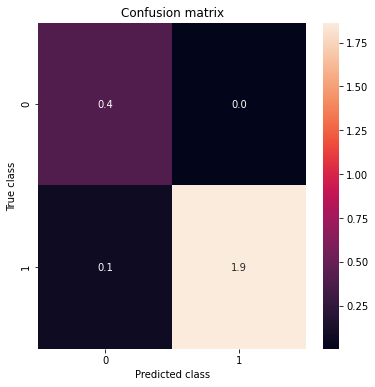

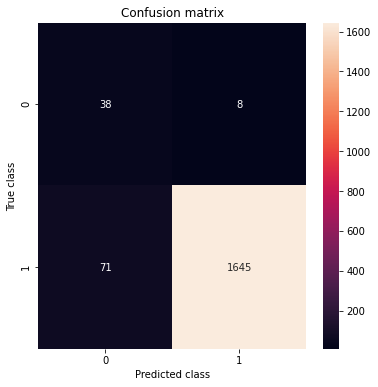

In [19]:
#eval_BC4_adasyn_20_SR2_Oct2020.json
eval = model.complete_evaluation(
    sets["x"]["test"], sets["y"]["test"], sets["w"]["test"], 0.8,
    save = True, dest_path = "./scores" , name = "adasyn_20_SR2_Oct2020",
)
print("Accuracy:", eval["weighted_accuracy"])
display(pd.DataFrame(eval["weighted_class_report"]))
plot_confidence_matrix(eval["weighted_cm"], 6, 6, '.1f')
plot_confidence_matrix(eval["cm"], 6, 6, 'd')